# Fantasy Points Against Defense Analysis

## 0. Welcome
In this project I will be analysizing fantasy football data to gain insight into how NFL players perform in fantasy against different defenses. For my initial dataset, I am pulling from the nflfastR-data repository. Code snippets in chapter 1-3 were borrowed from the user guide for nflfastR_python found [here](https://gist.github.com/Deryck97/dff8d33e9f841568201a2a0d5519ac5e) For more on the nflfastR project [click here](https://www.nflfastr.com/). Big shoutout to all the people behind nflfastR, this project would not have been possible without you! 

## 1. Configure Packages

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plydata import *
from plotnine import *
from adjustText import adjust_text


%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_colwidth', 500) # allow relatively long strings for desc column

## 2. Read Data
We are sourcing our information for the nflfastR data repository. For more info on this project [click here](https://github.com/nflverse/nflfastR)

In [4]:
YEAR = 2021
data = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/' \
                         'play_by_play_' + str(YEAR) + '.csv.gz?raw=True',
                         compression='gzip', low_memory=False) 

## 3. Save Data
Here we are saving data locally to avoid any additional network calls to retrieve the data again. 

In [5]:
data.to_csv(f'play_by_play_{YEAR}.csv.gz', compression='gzip', index=False)

## 4. Clean and Aggregate Data

In this chapter, I will be using the filters recommended by the nflfastR Python user guide by Deryck97 found [here](https://gist.github.com/Deryck97/dff8d33e9f841568201a2a0d5519ac5e). Before filtering the dataset, I will be checking it with aggregate functions to better understand the data and make decisions on what to include for the analysis. Note that we are sacrificing optimization here to slowly walkthrough the data, and validate and understand it as we go. We could refactor this code to perform better by filtering all at once, for example. 

#### 4.1 Filter out non-regular season games

The nflfastR dataset contains a field 'season_type'. Let's run a quick aggregate on that field to ensure we apply the correct filter. 



In [6]:
# let's group by season_type and return the count of plays for each
season_types = data.groupby(['season_type'], as_index=False)[['play_id']].count()
# Pretty up column names
season_types.rename(columns={season_types.columns[0]:'Season Type',season_types.columns[1]:'# Plays'}, inplace=True)
# Print Datatable
season_types.head() 

,Season Type,# Plays
0,POST,2298
1,REG,48414


Now that we know what we're filtering, let's filter to include only 'REG' season_type plays:

In [7]:
data = data.loc[data.season_type=='REG']

#### 4.2 Filter special teams plays, no plays, kneels, and spikes

Our dataset has a field 'play_type'. Let's query some aggregate information to get a sense of what that field contains:

In [8]:
play_types = data.groupby(['play_type'], as_index=False)[['play_id']].count()
play_types.rename(columns={play_types.columns[0]:'Play Type',play_types.columns[1]:'# Plays'}, inplace=True)
play_types #print datatable

,Play Type,# Plays
0,extra_point,1257
1,field_goal,1027
2,kickoff,2777
3,no_play,4519
4,pass,19997
5,punt,2078
6,qb_kneel,396
7,qb_spike,67
8,run,14142


This one has a lot more values than season_type. We immediately know we can exclude extra_point, field_goal, kickoff, and punt because they are special teams plays. We also know we need to include pass and run. I'm reasonably sure we can exclude no_play, qb_spike, and qb_kneel but let's get some more aggregate information about these values to confirm this. 


In [9]:
play_type_agg_info = data.loc[(data.play_type.isin(['extra_point', 'kickoff', 'punt', 'run', 'pass', 'field_goal'])==False)]\
                            .groupby(['play_type'], as_index=False)\
                            .agg({'play_id':'count',
                                  'rushing_yards':['max', 'min', 'mean', 'sum'],
                                  'passing_yards':['max','min', 'mean', 'sum'],
                                  'timeout': 'sum',
                                  'penalty': 'sum',
                                  'incomplete_pass': 'sum'})
play_type_agg_info 

play_type play_id rushing_yards                       passing_yards      \
              count           max  min      mean    sum           max min   
0   no_play    4519           NaN  NaN       NaN    0.0           NaN NaN   
1  qb_kneel     396           0.0 -4.0 -1.075758 -426.0           NaN NaN   
2  qb_spike      67           NaN  NaN       NaN    0.0           NaN NaN   

            timeout penalty incomplete_pass  
  mean  sum     sum     sum             sum  
0  NaN  0.0  2039.0  2442.0             0.0  
1  NaN  0.0     0.0     0.0             0.0  
2  NaN  0.0     0.0     0.0            67.0

Looking at this aggregate information, we can make some useful observations:
1. As expected, count of qb_spike plays is equal to the sum of incomplete_pass on those plays. 
2. Qb_kneel play types resulted in a range of 0.0 to -4.0 rushing yards, with a mean of -1.08. Over 400 yards were lost in the 2021 regular season due to kneeldowns, for a loss of over 40 fantasy points in most formats. This is a significant value, however, because the focus of this analysis will be on defensive performance, I want to exclude kneels and spikes.**\*** 
3. As expected, no_play has null (NaN) values for all rushing and passing yard aggregates, so we can safely ignore it for our analysis of defense. What is interesting howver, is that there are more no_plays than the sum of timeouts and penalties. Generally a no play is caused by a timeout or penalty, so what are these records that have neither? We will explore this in the following section. 

\* Note: this will cause a small discrepancy between fantasy points in this analysis vs fantasy points on platforms that negatively count kneeldowns for QB points.
##### Delving into unusual no_play data

In [10]:
no_play_no_timeout_no_penalty = data.loc[(data.play_type == 'no_play') & (data.timeout.isna()) & (data.penalty.isna()) ]
no_play_no_timeout_no_penalty[['desc','timeout', 'penalty','yards_gained','penalty_yards', 'penalty_team']].head()

,desc,timeout,penalty,yards_gained,penalty_yards,penalty_team
1567,"(:56) (Shotgun) 24-A.Gibson right end to LAC 24 for no gain (33-D.James). Penalty on WAS-24-A.Gibson, Face Mask (15 Yards), offsetting, enforced at LAC 24 - No Play. Penalty on LAC-33-D.James, Horse Collar Tackle, offsetting.",NaN,NaN,NaN,NaN,NaN
3213,"(8:17) (Shotgun) 17-J.Allen scrambles left end to BUF 28 for 4 yards (55-J.Baker). Penalty on BUF-73-D.Dawkins, Offensive Holding, offsetting, enforced at BUF 24 - No Play. Penalty on MIA-25-X.Howard, Defensive Holding, offsetting.",NaN,NaN,NaN,NaN,NaN
3309,"(:52) 14-A.Dalton pass short left to 32-D.Montgomery pushed ob at CIN 27 for 36 yards (24-V.Bell). Penalty on CIN-94-S.Hubbard, Roughing the Passer, offsetting, enforced at CHI 37 - No Play. Penalty on CHI-84-M.Goodwin, Offensive Holding, offsetting.",NaN,NaN,NaN,NaN,NaN
6857,"(:19) (Shotgun) 10-J.Garoppolo pass incomplete short right to 19-D.Samuel [52-R.Gary]. Penalty on SF-60-D.Brunskill, Offensive Holding, offsetting, enforced at GB 1 - No Play. Penalty on GB-94-D.Lowry, Illegal Use of Hands, offsetting.",NaN,NaN,NaN,NaN,NaN
11749,"(1:49) (Shotgun) 4-D.Carr scrambles right end ran ob at LV 34 for 5 yards (58-R.Smith). Penalty on CHI-98-B.Nichols, Illegal Use of Hands, offsetting, enforced at LV 29 - No Play. Penalty on LV-70-A.Leatherwood, Offensive Holding, offsetting.",NaN,NaN,NaN,NaN,NaN



Here we observe a unique quality of our data: plays in which two offsetting penalties occur, penalty has a null value. This is a good thing to remember, especially when analyzing penalty data. Filtering on penalty.isna() should be used with caution, and it may be worthwhile to join penalty data from another data source in some cases. 

Let's quickly check if any records exist in this subset that do *not* describe offsetting penalties:

In [11]:
len_all = len(no_play_no_timeout_no_penalty)
len_offset = len(no_play_no_timeout_no_penalty.loc[(no_play_no_timeout_no_penalty.desc.str.contains('offset', regex=False))])
print(f'Rows in subset: {len_all} \r\nRows in subset containing "offset" in desc: {len_offset}')

Rows in subset: 39 
Rows in subset containing "offset" in desc: 39


Now that we've confirmed the types of values in play_type, we can filter it to the ones we care about: 'run' and 'pass':

In [12]:
data = data.loc[(data.play_type.isin(['pass','run']))]

#### 4.3 Filter out null epa values

The final recommended filter from the user guide was `epa.isna() = False`

In [13]:
count_epa = len(data.loc[(data.epa.isna() == False)])
count_epa_na = len(data.loc[(data.epa.isna())])
print(f'Number of rows with non-null epa value: {count_epa}\r\nNumber of rows with null epa: {count_epa_na}')

Number of rows with non-null epa value: 34139
Number of rows with null epa: 0


It seems that if there were any non-null epa plays, they've already been excluded.

Let's quickly check if that is the case:

In [14]:
# load original dataset from csv it was saved in earlier
data_orig = pd.read_csv(f'play_by_play_{YEAR}.csv.gz',
                         compression='gzip', low_memory=False) 

In [15]:
count_epa = len(data_orig.loc[(data_orig.epa.isna() == False)])
count_epa_na = len(data_orig.loc[(data_orig.epa.isna())])
print(f'Number of rows with non-null epa value: {count_epa}\r\nNumber of rows with null epa: {count_epa_na}')

Number of rows with non-null epa value: 49857
Number of rows with null epa: 855


So some of the excluded plays did in fact have a null epa value. Let's group by a new column, 'play_type_nfl' to see what's going on with these:

In [16]:
d_null_epa = data_orig.loc[(data_orig.epa.isna())]
nfl_play_types = d_null_epa.groupby(['play_type_nfl'], as_index=False)[['play_id']].count()
nfl_play_types = nfl_play_types.rename(columns={nfl_play_types.columns[0]:'NFL play type', nfl_play_types.columns[1]:'Count'})
nfl_play_types

,NFL play type,Count
0,END_GAME,285
1,END_QUARTER,285
2,GAME_START,285


We can see here the 855 null epa rows are plays that represent special non-plays such as 'GAME_START' and 'END_GAME'. There are 285 of each, which is suspicious. Shouldn't there be 3 'END_QUARTER' for every 'END_GAME'?

Let's see what's going on:

In [17]:
end_qrtrs = d_null_epa.loc[(d_null_epa.play_type_nfl == 'END_QUARTER')]
end_qrtrs[['play_type','desc','game_seconds_remaining', 'home_team', 'away_team', 'week']].sort_values(['home_team','week']).head(5)

,play_type,desc,game_seconds_remaining,home_team,away_team,week
4724,NaN,END QUARTER 2,1800.0,ARI,MIN,2
14099,NaN,END QUARTER 2,1800.0,ARI,SF,5
18053,NaN,END QUARTER 2,1800.0,ARI,HOU,7
19804,NaN,END QUARTER 2,1800.0,ARI,GB,8
25006,NaN,END QUARTER 2,1800.0,ARI,CAR,10


Since we're sorting on home_team and week, if the data had end quarter records for quarters 1 or 3 we would see them here. 

We can conclude that for whatever reason, the special records are added for end of half but not end of quarter. I assume quarters 1 and 3 store the quarter end info with the last play of the quarter and the game start, end of Q2, and end of game post these seperate, special records.

We have already excluded the null epa from data by filtering on play_type in the previous section, but let's explicitly filter it anyway, in case our dataset changes in the future:

In [18]:
data = data.loc[(data.epa.isna() == False)]

#### 4.4 Filter out special teams plays

Let's take a look at the field `special_teams_play`:

In [19]:
data.groupby(['special_teams_play']).count()[['play_id']]

,play_id
special_teams_play,
0,34111
1,28


Somewhat surprisingly, there are still a small number of special teams plays. Probably mostly fake punts which get classified as passes. Let's eliminate them:

In [20]:
data = data.loc[(data.special_teams_play == 0)]

## 5. Load additional data and aggregate data for analysis

#### 5.1 Transforming plays into players

The main visualization we went to create on this dashboard will rank defenses vs each position, displaying yearly and weekly values for fantasy points against each defense. 

First, we must work on our data a bit. One difficulty we have is there can be multiple players scoring on each play. It would be convenient if we could first break out our data so that each row contains only contains one fantasy scorer. The most straight-forward way to do this is to break out the data into rushers, passers, and receivers. Then, we'll join on position data so we can group it by position.

In [21]:
rushers = data.loc[(data.rusher.isna() == False)].groupby([data.rusher, 
                                                          data.rusher_player_id,
                                                          data.week,
                                                          data.posteam,
                                                          data.defteam,
                                                          data.weather])\
                                                 .count()[['play_id']].reset_index()
rushers.rename(columns={rushers.columns[0] : 'player',
                        rushers.columns[1] : 'player_id',
                        rushers.columns[6] : 'plays'}, inplace=True)
rushers.head(3)

,player,player_id,week,posteam,defteam,weather,plays
0,A.Abdullah,00-0032104,1,MIN,CIN,"Mostly Sunny Temp: 84° F, Humidity: 48%, Wind: SW 10 mph, gusts to 13 mph",1
1,A.Abdullah,00-0032104,3,MIN,SEA,"N/A (Indoors) Temp: 77° F, Humidity: 44%, Wind: SSW 7 mph",5
2,A.Abdullah,00-0032104,5,MIN,DET,"N/A (Indoors) Temp: 66° F, Humidity: 69%, Wind: SW 12 mph",1


I'm pulling weather specifically because of how impactful it was last year. I think it might be an interesting point to reference, and I want to be able to explain why the Bills held Mac Jones to 0.5 points in week 13. 

`rushers` looks good, lets get `passers`:



In [22]:
passers = data.loc[(data.passer.isna() == False)].groupby([data.passer, 
                                                          data.passer_player_id,
                                                          data.week, 
                                                          data.posteam,
                                                          data.defteam,
                                                          data.weather])\
                                                 .count()[['play_id']].reset_index()
passers.rename(columns={passers.columns[0] : 'player',
                        passers.columns[1] : 'player_id',
                        passers.columns[6] : 'plays'}, inplace=True)
passers.head(3)

,player,player_id,week,posteam,defteam,weather,plays
0,A.Brown,00-0035676,8,TEN,IND,"Sunny Temp: 56° F, Humidity: 79%, Wind: WSW 5 mph",1
1,A.Brown,00-0035676,16,TEN,SF,"Clear Temp: 54° F, Humidity: 33%, Wind: South 6 mph",1
2,A.Dalton,00-0027973,1,CHI,LA,"Sunny Temp: 71° F, Humidity: 67%, Wind: WSW 10 mph",41


Looks like AJ Brown threw passes in two games in 2021. This is fine, we'll group Brown's records in `passers` with his records in `receivers` into `players` later on. 

For now let's get `receivers`:

In [23]:
receivers = data.loc[(data.receiver.isna() == False)].groupby([data.receiver, 
                                                          data.receiver_player_id,
                                                          data.week, 
                                                          data.posteam,
                                                          data.defteam,
                                                          data.weather])\
                                                     .count()[['play_id']].reset_index()
receivers.rename(columns={receivers.columns[0] : 'player',
                          receivers.columns[1] : 'player_id',
                          receivers.columns[6] : 'plays'}, inplace=True)
receivers.head(3)

,player,player_id,week,posteam,defteam,weather,plays
0,A.Abdullah,00-0032104,1,MIN,CIN,"Mostly Sunny Temp: 84° F, Humidity: 48%, Wind: SW 10 mph, gusts to 13 mph",2
1,A.Abdullah,00-0032104,2,MIN,ARI,Temp: Humidity: Wind: mph,1
2,A.Abdullah,00-0032104,4,MIN,CLE,"N/A (Indoors) Temp: 65° F, Humidity: 66%, Wind: NNW 11 mph",1


Since the dataframes `rushers`,`passers`, and `receivers` have matching indexes, we can easily combine them. Then, will we group by everything but `plays`, which we will take the sum of.

In [24]:
players = pd.concat([rushers, passers, receivers], ignore_index = True)
players.loc[(players.player_id == '00-0035676') & (players.week.isin([8, 16]))].head()

,player,player_id,week,posteam,defteam,weather,plays
2065,A.Brown,00-0035676,8,TEN,IND,"Sunny Temp: 56° F, Humidity: 79%, Wind: WSW 5 mph",1
2066,A.Brown,00-0035676,16,TEN,SF,"Clear Temp: 54° F, Humidity: 33%, Wind: South 6 mph",1
2767,A.Brown,00-0035676,8,TEN,IND,"Sunny Temp: 56° F, Humidity: 79%, Wind: WSW 5 mph",11
2771,A.Brown,00-0035676,16,TEN,SF,"Clear Temp: 54° F, Humidity: 33%, Wind: South 6 mph",16


In [25]:
players = players.groupby(['player', 
                           'player_id', 
                           'week', 
                           'posteam', 
                           'defteam', 
                           'weather']).sum()[['plays']].reset_index()

players.loc[(players.player_id == '00-0035676') & (players.week.isin([8, 16]))]

,player,player_id,week,posteam,defteam,weather,plays
39,A.Brown,00-0035676,8,TEN,IND,"Sunny Temp: 56° F, Humidity: 79%, Wind: WSW 5 mph",12
43,A.Brown,00-0035676,16,TEN,SF,"Clear Temp: 54° F, Humidity: 33%, Wind: South 6 mph",17


Notice that we don't yet have positional data, which makes sense because our groupings (`rusher`, `passer`, etc) come from a list of play data, with limited information about the players involved in the play. 

#### 5.2 Getting additional data

Let's get additional player data:

In [26]:
# load roster data from nflfastr data repository
roster_data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/rosters/roster_' 
                          + str(YEAR) + '.csv', low_memory=False) 

roster_data.head(3)

,season,team,position,depth_chart_position,jersey_number,status,full_name,first_name,last_name,birth_date,height,weight,college,high_school,gsis_id,espn_id,sportradar_id,yahoo_id,rotowire_id,pff_id,pfr_id,fantasy_data_id,sleeper_id,years_exp,headshot_url
0,2021,ARI,CB,RCB,7,Active,Byron Murphy,Byron,Murphy,1998-01-18,71,190.0,Washington,Saguaro (AZ),00-0035236,4038999.0,c025b513-9431-4097-bc25-9777bf08f846,31865.0,13560.0,44027.0,MurpBy00,20888.0,5864,3.0,"https://static.www.nfl.com/image/private/f_auto,q_auto/league/kd2eu8ugfgnv98qm88x6"
1,2021,ARI,CB,LCB,21,Active,Breon Borders,Breon,Borders,1995-07-22,72,189.0,Duke,Statesville (NC),00-0033435,3048663.0,d0fa2103-69a1-4ed0-a3cd-4eb8d5e342c2,30623.0,12097.0,39398.0,BordBr00,19300.0,4439,5.0,"https://static.www.nfl.com/image/private/f_auto,q_auto/league/uajgaowhpexewjakamce"
2,2021,ARI,CB,RCB,33,Active,Antonio Hamilton,Antonio,Hamilton,1993-01-24,72,188.0,South Carolina State,Strom Thurmond (SC),00-0032933,3056354.0,9bc107dc-1920-49db-b009-436d1a77955d,29957.0,11518.0,11353.0,HamiAn01,18658.0,3838,6.0,"https://static.www.nfl.com/image/private/f_auto,q_auto/league/ed99pz29nayfa4nbi8ob"


You may have wondered why I didn't get aggregated yardage/touchdown/2pt conversion metrics from the play data (`data`). I originally planned to, but I've since learned that the nflfastR data repository has already done it for us. Let's take advantage of this to streamline the process.

In [27]:
player_stats_data = pd.read_csv('https://github.com/nflverse/nflfastR-data/blob/master/data/'\
                                f'player_stats/player_stats_{YEAR}.csv.gz?raw=True',
                                compression='gzip', low_memory=False)
player_stats_data.head(3)

,player_id,player_name,recent_team,season,week,season_type,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,sack_fumbles,sack_fumbles_lost,passing_air_yards,passing_yards_after_catch,passing_first_downs,passing_epa,passing_2pt_conversions,pacr,dakota,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,rushing_2pt_conversions,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,00-0019596,T.Brady,TB,2021,1,REG,32,50,379,4,2,0,0,0,0,446,176,22,14.006987,0,0.849776,0.168449,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,NaN,NaN,0,27.16,27.16
1,00-0019596,T.Brady,TB,2021,2,REG,24,36,276,5,0,3,17,1,1,347,88,14,1.854364,0,0.795389,0.118404,1,6,0,0,0,1,1.284040,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,NaN,NaN,0,29.64,29.64
2,00-0019596,T.Brady,TB,2021,3,REG,41,55,432,1,0,3,21,1,0,382,238,24,13.163303,0,1.130890,0.137871,3,14,1,0,0,1,0.562927,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,NaN,NaN,0,28.68,28.68


Perfect! It has precalculated fantasy points, 2 pt conv data, and everything we need to calculate fantasy points if we want a custom scoring system. Technically this data isn't 'clean' to the standard we set with the play data (it has postseason games), but since we are doing a left join on it, we shouldn't pull any uncleaned data. 

#### 5.3 Joining data & checking outliers

We'll need parts from `players`,`player_stats_data`, and `roster_data`, so let's join them:

In [28]:
joined_data = pd.merge(players, #left
                       player_stats_data, #right
                       how='inner',
                       left_on=['player_id', 'week'],
                       right_on=['player_id', 'week'])

joined_data.head(3)

,player,player_id,week,posteam,defteam,weather,plays,player_name,recent_team,season,season_type,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,sack_fumbles,sack_fumbles_lost,passing_air_yards,passing_yards_after_catch,passing_first_downs,passing_epa,passing_2pt_conversions,pacr,dakota,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,rushing_2pt_conversions,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,A.Abdullah,00-0032104,1,MIN,CIN,"Mostly Sunny Temp: 84° F, Humidity: 48%, Wind: SW 10 mph, gusts to 13 mph",3,A.Abdullah,MIN,2021,REG,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,1,4,0,0,0,0,-0.568997,0,2,2,15,0,0,0,2,13,1,1.275328,0,7.5,0.042553,0.006601,0.068450,0,1.9,3.9
1,A.Abdullah,00-0032104,2,MIN,ARI,Temp: Humidity: Wind: mph,1,A.Abdullah,MIN,2021,REG,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,0,0,0,0,0,0,NaN,0,0,1,0,0,0,0,4,0,0,-1.062176,0,0.0,0.031250,0.019704,0.060668,0,0.0,0.0
2,A.Abdullah,00-0032104,3,MIN,SEA,"N/A (Indoors) Temp: 77° F, Humidity: 44%, Wind: SSW 7 mph",5,A.Abdullah,MIN,2021,REG,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,5,24,0,0,0,0,-0.288890,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,NaN,NaN,0,2.4,2.4


Looks good. But because I don't trust this data yet, let's run the previous join as left instead of inner to see if any players are missing their fantasy data:



In [29]:
left_joined_data = pd.merge(players, #left
                       player_stats_data, #right
                       how='left',
                       left_on=['player_id', 'week'],
                       right_on=['player_id', 'week'])


left_joined_data.loc[(left_joined_data.fantasy_points.isna())].head(5)

,player,player_id,week,posteam,defteam,weather,plays,player_name,recent_team,season,season_type,completions,attempts,passing_yards,passing_tds,interceptions,sacks,sack_yards,sack_fumbles,sack_fumbles_lost,passing_air_yards,passing_yards_after_catch,passing_first_downs,passing_epa,passing_2pt_conversions,pacr,dakota,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,rushing_2pt_conversions,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
5018,T.Johnson,00-0036427,16,TB,CAR,"Sunny Temp: 73° F, Humidity: 41%, Wind: WNW 5 mph",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Go back to the original play by play dataframe to view the plays that weren't found in player_stats 
odd = data.loc[(data.week == 16 ) &
         (
          (data.rusher_id == '00-0036427') |
          (data.receiver_id == '00-0036427') | 
          (data.passer_id == '00-0036427')
         )][['desc', 'rusher', 'passer', 'receiver']]
          
odd.head()
          

,desc,rusher,passer,receiver
42515,TWO-POINT CONVERSION ATTEMPT. 12-T.Brady pass to 18-T.Johnson is incomplete. ATTEMPT FAILS.,NaN,T.Brady,T.Johnson


So we are missing 1 row, but it makes sense because the play in question scored 0 fantasy points, and they didn't score fantasy points on any other plays in the game. We'll continue to use the inner joined data here, but it's good to confirm no fantasy points are slipping through the cracks. 

Let's now join our roster data:

In [31]:
tri_data = pd.merge(joined_data, #left
                       roster_data, #right
                       how='left',
                       left_on=['player_id'],
                       right_on=['gsis_id'])

#check for null roster data
null_roster_data = tri_data.loc[(tri_data.gsis_id.isna())].groupby(['player','player_id','week']).sum()[['plays']]
null_roster_data.head(10)

plays
player  player_id  week       
H.Ruggs 00-0036357 1         5
                   2         8
                   3         8
                   4         6
                   5         3
                   6         4
                   7         5
R.Smith 00-0035957 4         5

We've got some outliers. It looks like the roster data from nflfastR is updating to remove some players who get cut from the team. It's a bit of a hack, but let's look for players in the previous years roster as well. Note that for now we really only care getting the position from roster data, and if this continues to be a problem then we should consider refactoring to use a better reference for position data. 

In [32]:
# attempt to get roster_data from prev year
roster_data_prev_year = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/rosters/roster_' 
                          + str(YEAR - 1) + '.csv', low_memory=False)

# combine roster data with previous year roster data
two_year_roster_data = pd.concat([roster_data, roster_data_prev_year])

# get indexes for max year rows 
idx = two_year_roster_data.groupby(['gsis_id'])['season'].transform(max) == two_year_roster_data['season']

# subset down to max year rows (removes duplicates for most players)
two_year_roster_data = two_year_roster_data[idx]

outlier_ids = null_roster_data.index.get_level_values(1).unique()

# check our outliers to see if we now have them
outliers = two_year_roster_data.loc[(two_year_roster_data.gsis_id.isin(outlier_ids))]
outliers.head()

,season,team,position,depth_chart_position,jersey_number,status,full_name,first_name,last_name,birth_date,height,weight,college,high_school,gsis_id,espn_id,sportradar_id,yahoo_id,rotowire_id,pff_id,pfr_id,fantasy_data_id,sleeper_id,years_exp,headshot_url
402,2020,CAR,RB,NaN,35.0,Active,Rodney Smith,Rodney,Smith,1996-02-28,5-11,210.0,Minnesota,Mundy's Mill (GA),00-0035957,NaN,ee96c74a-7a51-478a-99f9-97ddaaac1e34,33153.0,14435.0,26306.0,NaN,21775.0,7101,NaN,NaN
1629,2020,LV,WR,LWR,11.0,Active,Henry Ruggs,Henry,Ruggs,1999-01-24,6-0,190.0,Alabama,Lee (AL),00-0036357,4241475.0,8a453858-7309-49ae-b8eb-de691847393f,32682.0,14473.0,61102.0,RuggHe00,21694.0,6789,NaN,https://a.espncdn.com/combiner/i?img=/i/headshots/nfl/players/full/4241475.png


So in the case of year 2021 we were able to look at the previous year's roster to get the positions for the outlier players who were missed in rosters. The code above will work other years, so if we change the year we will want to make sure players aren't missing. If this is a large problem for other years we definitely want to find a better data source for positions. 

Overwrite `tri_data` with a better version, fixing the outliers lacking position:

In [33]:
tri_data = pd.merge(joined_data, #left
                       two_year_roster_data, #right
                       how='left',
                       left_on=['player_id'],
                       right_on=['gsis_id'])

In [34]:
unconventional_ball_carriers = tri_data.loc[(tri_data.position.isin(['QB', 'RB', 'FB', 'TE', 'WR']) == False)]
unconventional_ball_carriers[['player', 'position', 'fantasy_points', 'week', 'posteam', 'defteam']]


,player,position,fantasy_points,week,posteam,defteam
406,A.Thomas,T,6.2,11,NYG,TB
965,C.McDermott,OL,6.1,16,NYJ,JAX
1113,C.Wilkins,DT,6.1,15,MIA,NYJ
1275,D.Dawkins,OT,0.0,17,BUF,ATL
1679,D.Pinter,G,6.2,9,IND,NYJ
2068,G.Bradbury,C,2.1,17,MIN,GB
3469,L.Johnson,T,6.5,16,PHI,NYG
3855,M.Nelson,T,0.0,17,DET,SEA
3883,M.Remmers,T,-0.2,1,KC,CLE
4864,T.Decker,T,-0.2,14,DET,DEN


One of the great things about this project is how much of a case study it is in outlier data. What we see here are the offensive lineman and defensive players who scored fantasy points in 2021. If we exclude it, I don't like how some defenses will "get a break" so to speak. The Jets gave up 12.3 points to these players in 2021, and excluding these records will essentially nullify those points.

Including them is also problematic. From a fantasy perspective, we don't care about these positions scoring except that they "vulture" the opportunity from a skill position player. So it doesn't make sense to pretend OL players are TEs and include them, they cost TEs opportunities. 

The best solution I have for now is to include an asterisk on games in which more than 2 fantasy points were scored by none skill positions. This is essentially what I plan to do for weather as well, so it will be very easy to include. 

Let's take the data we'll need for that asterisk for later:




In [ ]:
non_skill_pos_data = unconventional_ball_carriers.groupby(['week','posteam', 'defteam', 'weather']).sum()[['fantasy_points']]
non_skill_pos_data.reset_index(inplace=True)
non_skill_pos_data = non_skill_pos_data.loc[(non_skill_pos_data.fantasy_points > 2)]
#create a position column to represent these rows when joined
non_skill_pos_data['position'] = 'non_skill'
non_skill_pos_data[['week', 'posteam', 'defteam', 'fantasy_points']]

Now union this data with `tri_data`:

In [36]:
fixed_data = pd.concat([tri_data, non_skill_pos_data], ignore_index=True)

We still need to change 'FB' position to 'RB' and remove the positions we grouped together as 'non-skill'

In [37]:
fixed_data.loc['position'] = fixed_data['position'].replace('FB','RB')
fixed_data = fixed_data.loc[(fixed_data.position.isin(['QB', 'RB', 'WR', 'TE', 'non_skill' ]))]

Everything we need is finally in the same place and we are ready to aggregate it:

In [158]:
fpa_by_position = fixed_data.groupby(['week', 'defteam', 'posteam', 'position', 'weather']).sum()[['fantasy_points']]

fpa_by_position.reset_index(inplace=True)
fpa_by_position.loc[(fpa_by_position.week == 9) & (fpa_by_position.defteam == 'NYJ')]

,week,defteam,posteam,position,weather,fantasy_points
1068,9.0,NYJ,IND,QB,"Cloudy Temp: 44° F, Humidity: 54%, Wind: N 2 mph",24.28
1069,9.0,NYJ,IND,RB,"Cloudy Temp: 44° F, Humidity: 54%, Wind: N 2 mph",48.80
1070,9.0,NYJ,IND,TE,"Cloudy Temp: 44° F, Humidity: 54%, Wind: N 2 mph",11.60
1071,9.0,NYJ,IND,WR,"Cloudy Temp: 44° F, Humidity: 54%, Wind: N 2 mph",21.20
1072,9.0,NYJ,IND,non_skill,"Cloudy Temp: 44° F, Humidity: 54%, Wind: N 2 mph",6.20


This is exactly the format we need, now let's make a chart:

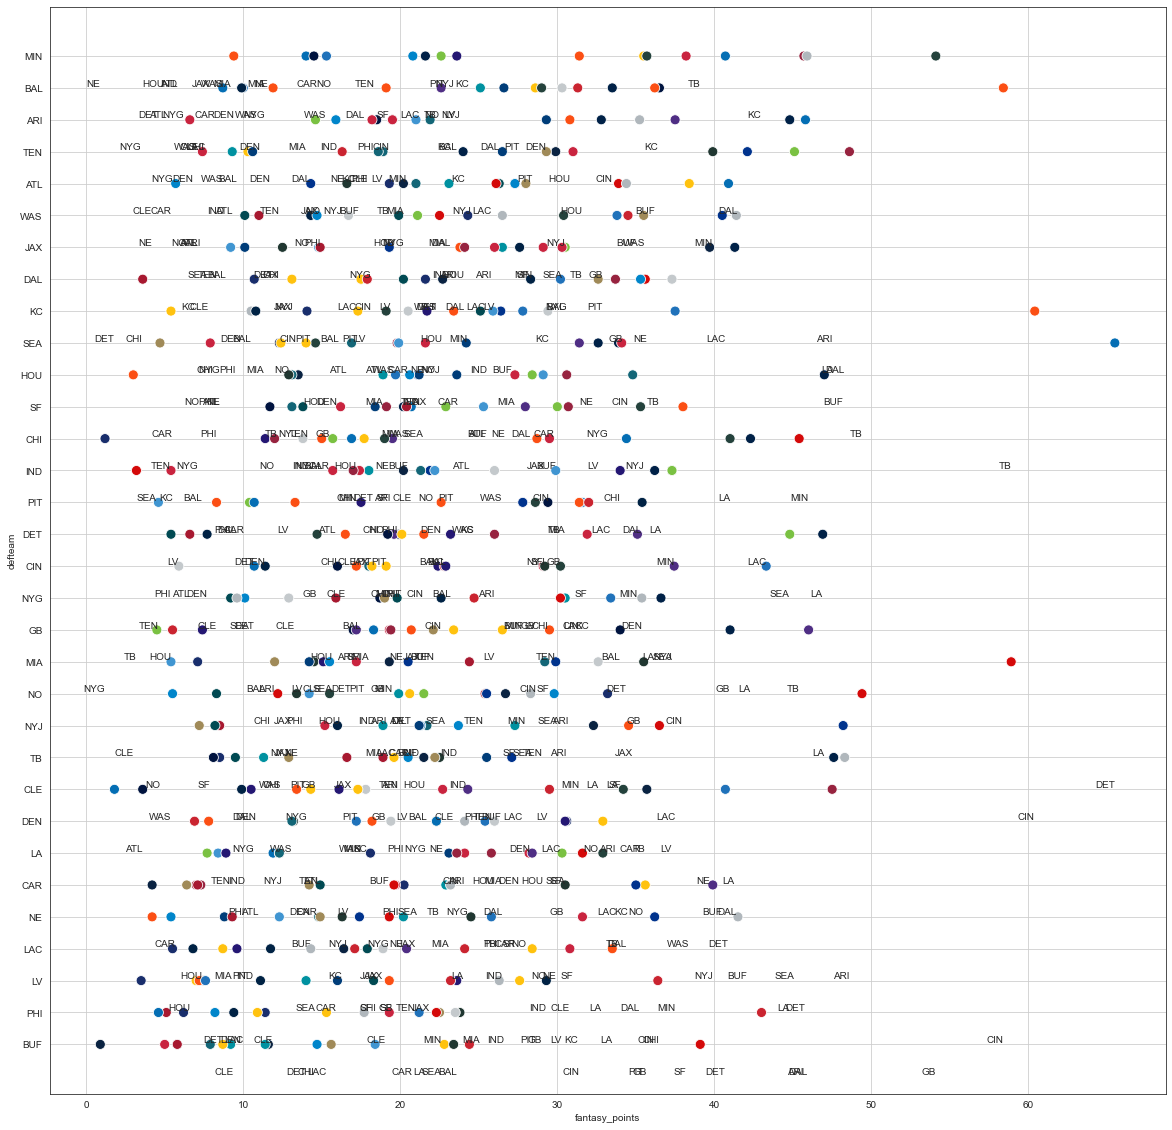

In [183]:
plot_data = fpa_by_position.loc[(fpa_by_position.position == 'WR') & (fpa_by_position.week != 18)].sort_values('fantasy_points', ascending=False)

fig, ax = plt.subplots(figsize=(20,20))


#Add grid
ax.grid(zorder=0,alpha=1)
ax.set_axisbelow(True)

#Map the COLORS dictionary to the posteam column
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

plot_data['color'] = plot_data['posteam'].map(COLORS)

#Create a dictionary of each teams season rank to determine place on y axis
d_y = {}
defteam_avg_fpoints = plot_data.groupby(['defteam']).mean()[['fantasy_points']].reset_index().sort_values('fantasy_points')
for i in range(len(defteam_avg_fpoints.defteam)):
    rank = i + 1 #Change 0 based rank to 1 based for visual purposes 
    team = defteam_avg_fpoints.iloc[i].defteam
    d_y[team] = rank

#Map y axis values
plot_data['rank'] = plot_data['defteam'].map(d_y)

#sort by rank
plot_data = plot_data.sort_values('rank', ascending=False)

#plot_data.head()
#Create the scatterplot
sns.scatterplot(x=plot_data.fantasy_points, y=plot_data.defteam, c =plot_data.color, s=100)

#Add labels to each data point
#texts = [plt.text(x0,y0,name,ha='right',va='bottom') for x0,y0,name in zip(
 #   plot_data.fantasy_points, plot_data['rank'], plot_data.posteam)]

